# gradient normalisation and momentum implementation



In [2]:
import networks
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [13]:
# load datasets

data_dir = Path("data")
square_large_train = pd.read_csv(data_dir / "regression" / "square-large-training.csv", index_col=0)
square_large_test = pd.read_csv(data_dir / "regression" / "square-large-test.csv", index_col=0)
steps_large_train = pd.read_csv(data_dir / "regression" / "steps-large-training.csv", index_col=0)
steps_large_test = pd.read_csv(data_dir / "regression" / "steps-large-test.csv", index_col=0)
multimodal_large_train = pd.read_csv(data_dir / "regression" / "multimodal-large-training.csv")
multimodal_large_test = pd.read_csv(data_dir / "regression" / "multimodal-large-test.csv")


# square large train

visualisation of neural network weights will be done using a basic barplot

In [4]:
layers = [
    {"output_dim": 30, "activation": "relu", "init": "he"},
    {"output_dim": 30, "activation": "relu", "init": "he"},
    {"activation": "linear", "init": "normal"}
]

mlp = networks.MLP(layers, input=square_large_train[["x"]].T)


initializing layer 0 using he initialization
initializing layer 1 using he initialization
initializing layer 2 using normal initialization


In [5]:
norm = networks.assets.Normalizator(square_large_train)

square_large_train_norm = norm(square_large_train)
square_large_test_norm = norm(square_large_test)

initializing layer 0 using he initialization
initializing layer 1 using he initialization
initializing layer 2 using normal initialization
Epoch: 0, Loss: 10.54659274308991
Epoch: 100, Loss: 0.009570281454659327


Epoch: 200, Loss: 0.005250922229828476
Epoch: 300, Loss: 0.002931512696304722
Epoch: 400, Loss: 0.0019496694670872916
Epoch: 500, Loss: 0.0015482070568162709
Epoch: 600, Loss: 0.0013377028164193855
Epoch: 700, Loss: 0.0011604837784641123
Epoch: 800, Loss: 0.001048995754314871
Epoch: 900, Loss: 0.0009799136190421574
Epoch: 1000, Loss: 0.0009347658812348353
Epoch: 1100, Loss: 0.0008985996619253944
Epoch: 1200, Loss: 0.0008668064524505785
Epoch: 1300, Loss: 0.0008400417553850057
Epoch: 1400, Loss: 0.0008138174120831926
Epoch: 1500, Loss: 0.0007914663839977697
Epoch: 1600, Loss: 0.0007702626122819475
Epoch: 1700, Loss: 0.0007491449371680836
Epoch: 1800, Loss: 0.0007303361546264084
Epoch: 1900, Loss: 0.0007132831273421416
Epoch: 2000, Loss: 0.0006977533912976507
Epoch: 2100, Loss: 0.0006831243118716941
Epoch: 2200, Loss: 0.0006694047278200391
Epoch: 2300, Loss: 0.000655788962552806
Epoch: 2400, Loss: 0.0006420910141062179
Epoch: 2500, Loss: 0.0006280256763461943
Epoch: 2600, Loss: 0.0006151

Text(0.5, 1.0, 'Loss of the model with momentum decay 0.9')

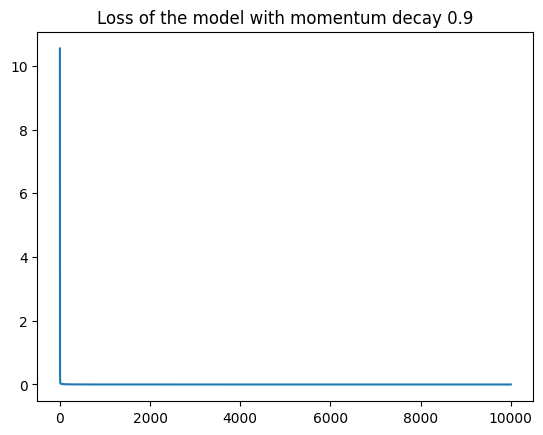

In [6]:
mlp = networks.MLP(layers, input=square_large_train_norm[["x"]].T)

losses = mlp.train(square_large_train_norm[["x"]].T.to_numpy(), square_large_train_norm[["y"]].T.to_numpy(), learning_rate=0.01, max_epochs=10000, batch_size=256, momentum=True, momentum_rate=0.9)


plt.plot(losses)
plt.title("Loss of the model with momentum decay 0.9")

MSE: 1.9437944788326533


Text(0.5, 1.0, 'Prediction of the model with momentum decay 0.9, num of epochs: 50000')

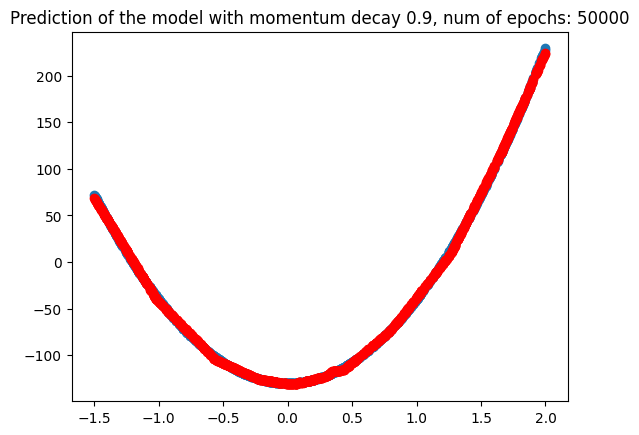

In [7]:
y_hat = mlp.full_forward_pass(square_large_train_norm[["x"]].T)

plt.scatter(square_large_train["x"], square_large_train["y"])
plt.scatter(square_large_train["x"], norm.denorm(y_hat.T, index="y"), color="red")

print("MSE:", np.mean((square_large_train["y"] - norm.denorm(y_hat.T, index="y").to_numpy().flatten())**2))
plt.title("Prediction of the model with momentum decay 0.9, num of epochs: 50000")

MSE: 70.29676381783264


Text(0.5, 1.0, 'Prediction of the model with momentum decay 0.9, num of epochs: 50000')

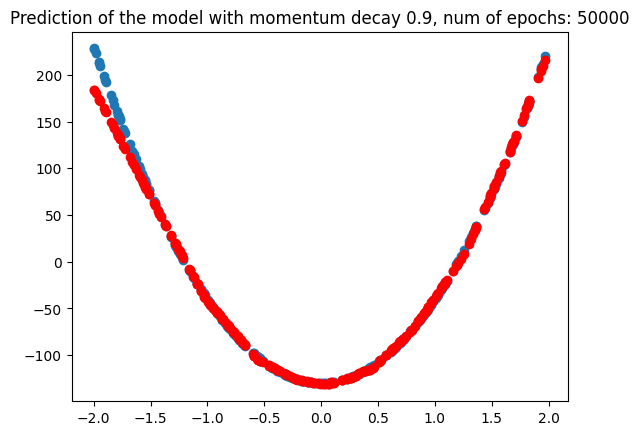

In [8]:
y_hat = mlp.full_forward_pass(square_large_test_norm[["x"]].T)

plt.scatter(square_large_test["x"], square_large_test["y"])
plt.scatter(square_large_test["x"], norm.denorm(y_hat.T, index="y"), color="red")

print("MSE:", np.mean((square_large_test["y"] - norm.denorm(y_hat.T, index="y").to_numpy().flatten())**2))
plt.title("Prediction of the model with momentum decay 0.9, num of epochs: 50000")

initializing layer 0 using he initialization
initializing layer 1 using he initialization
initializing layer 2 using normal initialization
Epoch: 0, Loss: nan
Epoch: 100, Loss: nan


d:\studia\sem6\miowad\miowad\NN\networks\mlp.py:178: RuntimeWarning: divide by zero encountered in divide
  dw = [dw[i] / np.sqrt(squared_gradients[i]) for i in range(self.depth)]
d:\studia\sem6\miowad\miowad\NN\networks\mlp.py:178: RuntimeWarning: invalid value encountered in divide
  dw = [dw[i] / np.sqrt(squared_gradients[i]) for i in range(self.depth)]
d:\studia\sem6\miowad\miowad\NN\networks\layers.py:130: RuntimeWarning: invalid value encountered in matmul
  self.linear_output = np.matmul(self.weights,  input) + self.bias


Epoch: 200, Loss: nan
Epoch: 300, Loss: nan
Epoch: 400, Loss: nan
Epoch: 500, Loss: nan
Epoch: 600, Loss: nan
Epoch: 700, Loss: nan
Epoch: 800, Loss: nan
Epoch: 900, Loss: nan
Epoch: 1000, Loss: nan
Epoch: 1100, Loss: nan
Epoch: 1200, Loss: nan
Epoch: 1300, Loss: nan
Epoch: 1400, Loss: nan
Epoch: 1500, Loss: nan
Epoch: 1600, Loss: nan
Epoch: 1700, Loss: nan
Epoch: 1800, Loss: nan
Epoch: 1900, Loss: nan
Epoch: 2000, Loss: nan
Epoch: 2100, Loss: nan
Epoch: 2200, Loss: nan
Epoch: 2300, Loss: nan
Epoch: 2400, Loss: nan
Epoch: 2500, Loss: nan
Epoch: 2600, Loss: nan
Epoch: 2700, Loss: nan
Epoch: 2800, Loss: nan
Epoch: 2900, Loss: nan
Epoch: 3000, Loss: nan
Epoch: 3100, Loss: nan
Epoch: 3200, Loss: nan
Epoch: 3300, Loss: nan
Epoch: 3400, Loss: nan
Epoch: 3500, Loss: nan
Epoch: 3600, Loss: nan
Epoch: 3700, Loss: nan
Epoch: 3800, Loss: nan
Epoch: 3900, Loss: nan
Epoch: 4000, Loss: nan
Epoch: 4100, Loss: nan
Epoch: 4200, Loss: nan
Epoch: 4300, Loss: nan
Epoch: 4400, Loss: nan
Epoch: 4500, Loss: 

Text(0.5, 1.0, 'Loss of the model with squared gradient decay 0.9')

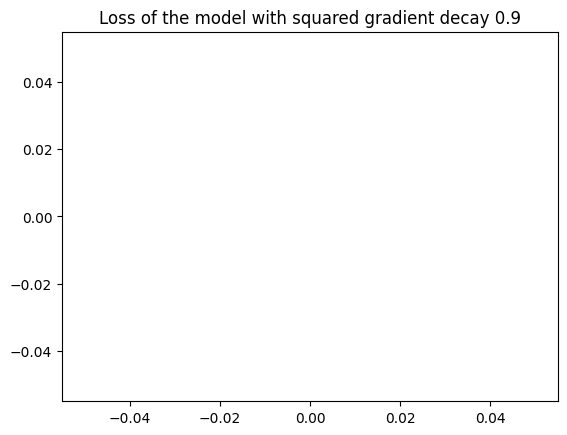

In [9]:
mlp = networks.MLP(layers, input=square_large_train_norm[["x"]].T)

losses = mlp.train(square_large_train_norm[["x"]].T.to_numpy(), square_large_train_norm[["y"]].T.to_numpy(), learning_rate=0.01, max_epochs=10000, batch_size=256, rms_prop=True, squared_gradient_decay=0.9)


plt.plot(losses)
plt.title("Loss of the model with squared gradient decay 0.9")

MSE: nan


Text(0.5, 1.0, 'Prediction of the model with squared gradient decay 0.9, num of epochs: 10000')

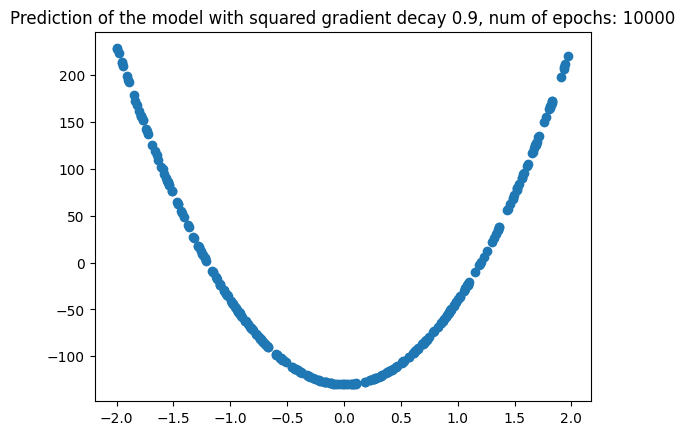

In [10]:
y_hat = mlp.full_forward_pass(square_large_test_norm[["x"]].T)

plt.scatter(square_large_test["x"], square_large_test["y"])
plt.scatter(square_large_test["x"], norm.denorm(y_hat.T, index="y"), color="red")

print("MSE:", np.mean((square_large_test["y"] - norm.denorm(y_hat.T, index="y").to_numpy().flatten())**2))
plt.title("Prediction of the model with squared gradient decay 0.9, num of epochs: 10000")

## steps large 

In [14]:
layers = [
    {"output_dim": 10, "activation": "relu", "init": "he"},
    #{"output_dim": 3, "activation": "relu", "init_method": "he"},
    {"output_dim": 3, "activation": "relu", "init": "he"},
    {"output_dim": 5, "activation": "relu", "init": "normal"},

    {"activation": "linear", "init": "normal"}
]



norm_steps = networks.assets.Normalizator(steps_large_train)
steps_large_train_norm = norm_steps(steps_large_train)
steps_large_test_norm = norm_steps(steps_large_test)

mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T)


initializing layer 0 using he initialization
initializing layer 1 using he initialization
initializing layer 2 using normal initialization
initializing layer 3 using normal initialization


In [15]:
steps_large_train_norm[["x"]].T.to_numpy().shape[1]

10000

In [16]:
mlp_steps = networks.MLP(layers, input=steps_large_train_norm[["x"]].T)


losses = mlp_steps.train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), momentum=True, momentum_rate=0.9,
                         max_epochs=10000, learning_rate = 0.1, batch_size=32)
# losses = mlp_steps.minibatch_train(steps_large_train_norm[["x"]].T.to_numpy(), steps_large_train_norm[["y"]].T.to_numpy(), 0.1, 20000)

plt.plot(losses[100:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

initializing layer 0 using he initialization
initializing layer 1 using he initialization
initializing layer 2 using normal initialization
initializing layer 3 using normal initialization
Epoch: 0, Loss: 0.06780694789217676
Epoch: 100, Loss: 0.06166127067446696
Epoch: 200, Loss: 0.06127203684694813
Epoch: 300, Loss: 0.06103577421187606
Epoch: 400, Loss: 0.06087902819969664
Epoch: 500, Loss: 0.06076409600109048
Epoch: 600, Loss: 0.06069304375593064
Epoch: 700, Loss: 0.06062405515081366
Epoch: 800, Loss: 0.06055760992085976
Epoch: 900, Loss: 0.06050912544335251
Epoch: 1000, Loss: 0.06047449509502694
Epoch: 1100, Loss: 0.060445112244505536


: 

MSE on train data:  0.06808134887893778


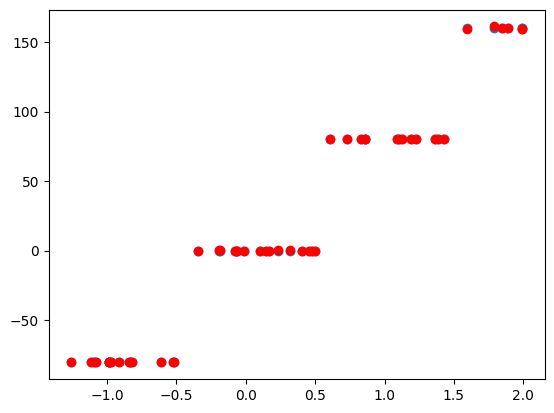

In [82]:
y_hat = mlp_steps.full_forward_pass(steps_large_train_norm[["x"]].T).to_numpy()

plt.scatter(steps_large_train["x"], steps_large_train["y"])
plt.scatter(steps_large_train["x"], norm_steps.denorm(y_hat.T, index="y"), color="red")

mse = np.mean((steps_large_train["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on train data: ", mse)

MSE on test data:  127.21709701174007


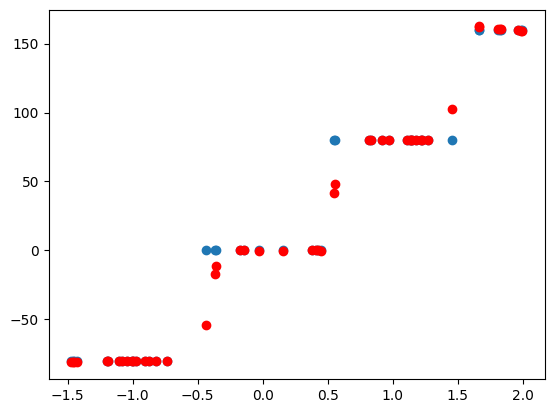

In [83]:
y_hat = mlp_steps.full_forward_pass(steps_large_test_norm[["x"]].T.to_numpy())

plt.scatter(steps_large_test["x"], steps_large_test["y"])
plt.scatter(steps_large_test["x"], norm_steps.denorm(y_hat.T, index="y"), color="red")

mse = np.mean((steps_large_test["y"] - norm_steps.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on test data: ", mse)

# Multimodal large

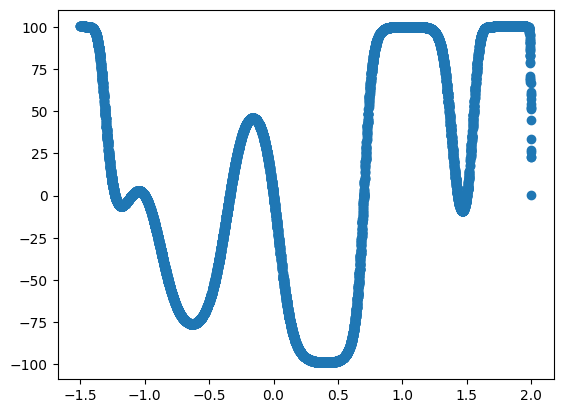

In [4]:

norm_multimodal = networks.assets.Normalizator(multimodal_large_train)

multimodal_large_train_norm = norm_multimodal(multimodal_large_train)
multimodal_large_test_norm = norm_multimodal(multimodal_large_test)

plt.scatter(multimodal_large_train["x"], multimodal_large_train["y"])

In [5]:
multimodal_large_train_norm.std()

x    1.0
y    1.0
dtype: float64

In [6]:
layers = [
    {"output_dim": 20, "activation": "relu", "init": "he"},
    {"output_dim": 20, "activation": "relu", "init": "he"},
    {"activation": "linear", "init": "normal"}
]



mlp_multimodal = networks.MLP(layers, input=multimodal_large_train_norm[["x"]].T)


losses = mlp_multimodal.train(multimodal_large_train_norm[["x"]].T.to_numpy(), multimodal_large_train_norm[["y"]].T.to_numpy(), max_epochs=10000, batch_size=256, loss_stop = 1e-8, learning_rate=0.2, momentum=True, momentum_decay=0.5)

plt.plot(losses)

initializing layer 0 using he initialization
initializing layer 1 using he initialization
initializing layer 2 using normal initialization
Epoch: 0, Loss: 0.4938181571181778


Epoch: 100, Loss: 0.08857645997313528
Epoch: 200, Loss: 0.08670471041315501
Epoch: 300, Loss: 0.08578673060127064
Epoch: 400, Loss: 0.08519011364756504
Epoch: 500, Loss: 0.08481068165710327
Epoch: 600, Loss: 0.08452190467479419
Epoch: 700, Loss: 0.08428389965445833
Epoch: 800, Loss: 0.08407414227977882
Epoch: 900, Loss: 0.0838991459823212
Epoch: 1000, Loss: 0.08375286546201952
Epoch: 1100, Loss: 0.08362386573696158
Epoch: 1200, Loss: 0.08351036671976013
Epoch: 1300, Loss: 0.08341186055377123
Epoch: 1400, Loss: 0.0833206160163921
Epoch: 1500, Loss: 0.08323707301657794
Epoch: 1600, Loss: 0.08316127301404468
Epoch: 1700, Loss: 0.08309333373940567
Epoch: 1800, Loss: 0.08303278629931403
Epoch: 1900, Loss: 0.0829779584959656
Epoch: 2000, Loss: 0.08292554901731727
Epoch: 2100, Loss: 0.08287559172733243
Epoch: 2200, Loss: 0.08283389813574468
Epoch: 2300, Loss: 0.08279375034072516
Epoch: 2400, Loss: 0.0827538188959339
Epoch: 2500, Loss: 0.08271564720899797
Epoch: 2600, Loss: 0.08268455078808207

Text(0.5, 1.0, 'Training Loss')

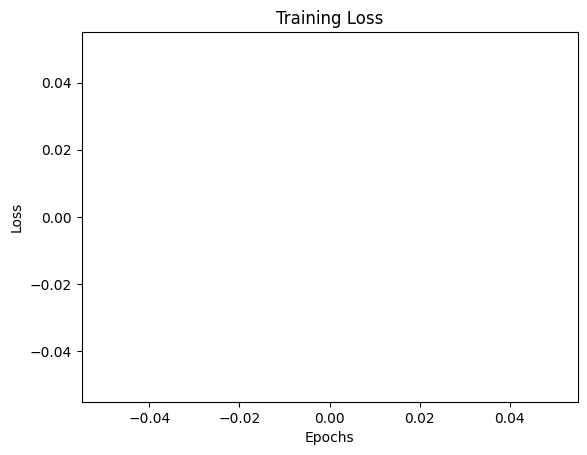

In [87]:
plt.plot(losses[5000:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

MSE on test data:  186.95622425313445


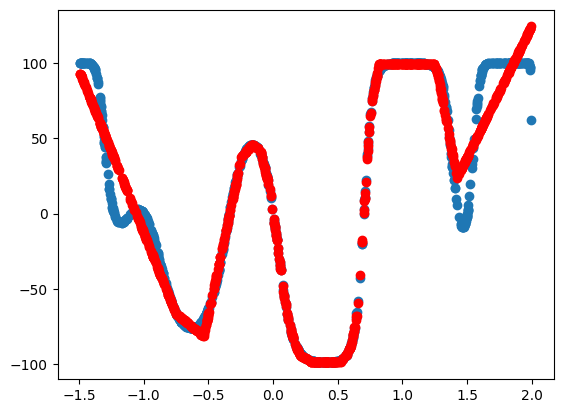

In [92]:
y_hat = mlp_multimodal.full_forward_pass(multimodal_large_test_norm[["x"]].T.to_numpy())

plt.scatter(multimodal_large_test["x"], multimodal_large_test["y"])
plt.scatter(multimodal_large_test["x"], norm_multimodal.denorm(y_hat.T, index="y"), color="red")

mse = np.mean((multimodal_large_test["y"] - norm_multimodal.denorm(y_hat.T, index="y").flatten())**2)
print("MSE on test data: ", mse)